In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [8]:
train = pd.read_csv('/Users/choejeehyuk/경4났조/235583_행동 데이터 분석 인공지능 AI 경진대회_data/train.csv')
train = train[train.event == 'Camera']

In [9]:
train.head()

,game_id,winner,time,player,species,event,event_contents
0,0,1,0.00,0,T,Camera,"at (145.25, 21.5078125)"
1,0,1,0.00,1,T,Camera,"at (22.75, 147.0078125)"
4,0,1,0.14,0,T,Camera,"at (142.99609375, 24.50390625)"
5,0,1,0.14,0,T,Camera,"at (142.5078125, 24.98828125)"
6,0,1,0.14,0,T,Camera,"at (139.6171875, 27.8828125)"


In [10]:
train.event_contents = train.event_contents.str.split('(').str[1]
train.event_contents = train.event_contents.str.split(')').str[0]
train['Camera_loc_x'] = train.event_contents.str.split(',').str[0].astype('float')
train['Camera_loc_y'] = train.event_contents.str.split(',').str[1].astype('float')

In [11]:
train.head()

,game_id,winner,time,player,species,event,event_contents,Camera_loc_x,Camera_loc_y
0,0,1,0.00,0,T,Camera,"145.25, 21.5078125",145.250000,21.507812
1,0,1,0.00,1,T,Camera,"22.75, 147.0078125",22.750000,147.007812
4,0,1,0.14,0,T,Camera,"142.99609375, 24.50390625",142.996094,24.503906
5,0,1,0.14,0,T,Camera,"142.5078125, 24.98828125",142.507812,24.988281
6,0,1,0.14,0,T,Camera,"139.6171875, 27.8828125",139.617188,27.882812


In [ ]:
train.to_csv('/Users/choejeehyuk/경4났조/235583_행동 데이터 분석 인공지능 AI 경진대회_data/train_coordinate.csv')

In [ ]:
train = pd.read_csv('/Users/choejeehyuk/경4났조/235583_행동 데이터 분석 인공지능 AI 경진대회_data/train_coordinate.csv')

#### 두 명의 카메라 기록을 저장할 2채널 192x92 이미지 생성, 3번째 채널은 미사용

In [12]:
def draw_trace(game_id):
    trace = np.zeros([192, 192,3], float) # 두 명의 카메라 기록을 저장할 2채널 192x92 이미지 생성, 3번째 채널은 미사용
    
    # 플레이어0의 카메라 기록을 Red 채널에 저장
    r = np.array(train[(train.game_id=='game_id')&(train.player==0)].loc[:, ['Camera_loc_x', 'Camera_loc_y']])
    try:
        r, c = np.unique(r, axis = 0, return_counts=True) # r은 좌표, c는 좌표 등장 횟수
        c = c.reshape([c.shape[0],1]) #shape[0], shape[1]를 이용하여 전체 행의 갯수와 열의 갯수를 반환받을 수 있다.
        r = np.concatenate((r, c), axis = 1)
        for loc in r:
            trace[192-int(loc[1]), int(loc[0]), 0] = loc[2] # y축과 배열의 방향이 반대여서 보정
        del r
    except: # 카메라 이벤트가 한번도 없을 경우
        del r
        pass
    
    # 플레이어1의 카메라 기록을 Green 채널에 저장
    g = np.array(train[(train.game_id=='game_id')&(train.player==1)].loc[:, ['Camera_loc_x', 'Camera_loc_y']])
    try:
        g, c = np.unique(g, axis = 0, return_counts=True)
        c = c.reshape([c.shape[0],1])
        g = np.concatenate((g, c), axis = 1)
        for loc in g:
            trace[192-int(loc[1]), int(loc[0]), 1] = loc[2]
        del g
    except:
        del g
        pass
    
    trace[:,:,0] /= (np.max(trace[:,:,0])+1e-6) # R 채널 0~1로 정규화
    trace[:,:,1] /= (np.max(trace[:,:,1])+1e-6) # G 채널 0~1로 정규화
    
    return trace

https://jvvp.tistory.com/1085

In [13]:
def show_img(trace):
    plt.imshow(trace)
    plt.show()
    print('카메라 좌표를 점으로만 표시\n\n')
    
    trace = cv2.dilate(trace, np.ones((20,30))) # diation. 점이 필터사이즈(20,30)로 변함.
    plt.imshow(trace)
    plt.show()
    print('dilation을 이용하여 보이는 영역 표시\n\n')
    
    battle = trace[:,:,0]*trace[:,:,1]
    battle /= np.max(battle)
    plt.imshow(battle)
    plt.show()
    print('각 플레이어의 화면을 곱하여 공통으로 본 영역만 남김\n\n')
    
    battle = np.where(battle!=1, 0, battle)
    plt.imshow(battle)
    plt.show()
    print('가장 많이 겹친 지역만 남김\n\n')
    
    battle = battle*255
    battle = battle.astype('uint8')
    nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(battle)
    x, y, width, height, area = stats[1]
    print('center_x :', x+width/2, 'center_y :', y+height/2, 'area :', area)

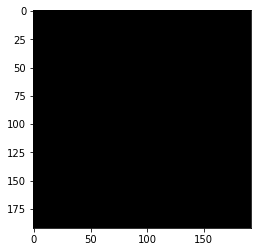

카메라 좌표를 점으로만 표시




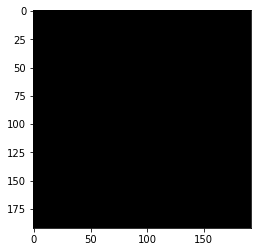

dilation을 이용하여 보이는 영역 표시




/var/folders/fs/kl20xgn54d3bgs5lpqcv3b_00000gn/T/ipykernel_1050/3448377798.py:12: RuntimeWarning: invalid value encountered in true_divide
  battle /= np.max(battle)


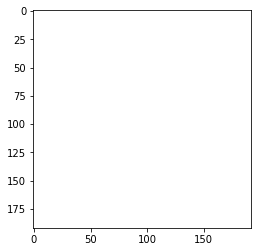

각 플레이어의 화면을 곱하여 공통으로 본 영역만 남김




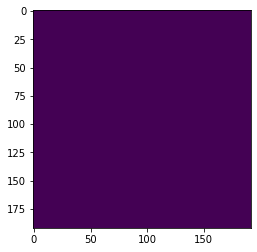

가장 많이 겹친 지역만 남김




IndexError: index 1 is out of bounds for axis 0 with size 1

In [14]:
trace = draw_trace(0)
show_img(trace)

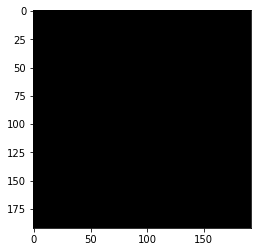

카메라 좌표를 점으로만 표시




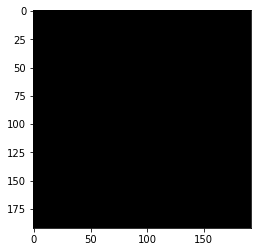

dilation을 이용하여 보이는 영역 표시




/var/folders/fs/kl20xgn54d3bgs5lpqcv3b_00000gn/T/ipykernel_1050/3448377798.py:12: RuntimeWarning: invalid value encountered in true_divide
  battle /= np.max(battle)


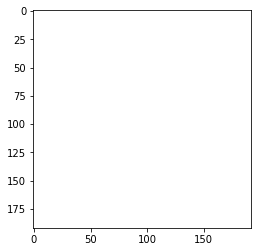

각 플레이어의 화면을 곱하여 공통으로 본 영역만 남김




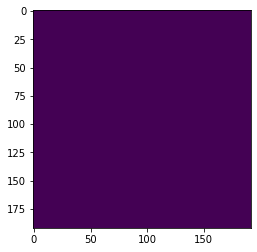

가장 많이 겹친 지역만 남김




IndexError: index 1 is out of bounds for axis 0 with size 1

In [15]:
trace = draw_trace(99)
show_img(trace)